# Generate yellow smiley faces 🙂

## load dependencies
* matplotlib for plotting
* numpy for array handling
* json for loading emoji description
* mpimg and glob for reading PNG
* tensorflow for GAN

In [30]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import json
import glob
import random
from pprint import pprint

## filter and load emoji files

In [31]:
# filter only person emojis without tones
with open('emojione-2.2.7/emoji.json') as data_file:
    emojis = json.load(data_file)

smileys = {k: v for k, v in emojis.items() if v["category"] == "people" and not "_tone" in k}
pprint("original dictionary:")
pprint({key: smileys[key] for key in list(smileys.keys())[:1]})

smileys = {k: {"keywords": v["keywords"], "unicode": v["unicode"], "ascii": v["aliases_ascii"], "name": v["name"]} for k,v in smileys.items()}
pprint("minimized dictionary: {} left out of {} emojis".format(len(smileys), len(emojis)))
pprint({key: smileys[key] for key in list(smileys.keys())[:2]})

'original dictionary:'
{'pregnant_woman': {'aliases': [':expecting_woman:'],
                    'aliases_ascii': [],
                    'category': 'people',
                    'code_decimal': '&#129328;',
                    'emoji_order': '483',
                    'keywords': [],
                    'name': 'pregnant woman',
                    'shortname': ':pregnant_woman:',
                    'unicode': '1f930',
                    'unicode_alt': ''}}
'minimized dictionary: 225 left out of 1820 emojis'
{'fingers_crossed': {'ascii': [],
                     'keywords': [],
                     'name': 'hand with first and index finger crossed',
                     'unicode': '1f91e'},
 'pregnant_woman': {'ascii': [],
                    'keywords': [],
                    'name': 'pregnant woman',
                    'unicode': '1f930'}}


In [32]:
# filter all files for the given smiley unicodes
image_paths = glob.glob("./emojione-2.2.7/assets/png/*.png")
#pprint(image_paths[:10])
filtered_files = [v["unicode"] for k,v in smileys.items()]
filtered_files = [next(filter(lambda p: f+".png" in p, image_paths)) for f in filtered_files]

In [33]:
# load all files
images = [mpimg.imread(f) for f in filtered_files]

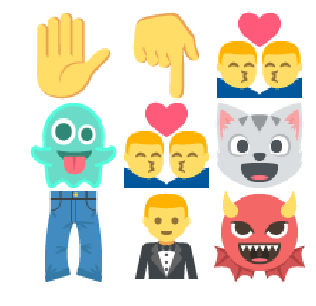

In [34]:
# display 20 random emojis
column_count = 3 # emojis per column
display_count = column_count**2 # total number of emojis to show (aligns neatly if it's a square)

f, axarr = plt.subplots(display_count//column_count, column_count, sharex=True, sharey=True, figsize=(5,5))
for (i, img) in enumerate(random.sample(images, display_count)):
    a = axarr[i%(display_count//column_count), i//(display_count//column_count)]
    a.axis("off")
    a.imshow(img)
plt.subplots_adjust(wspace=0, hspace=0)

## preprocessing functions

In [35]:
def scale(x, min_val=-1, max_val=1):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    x = x * (max_val - min_val) + min_val
    return x

In [36]:
def get_batches(images, batch_size, shuffle=True):
    images = np.array(images)
    if shuffle:
        idx = np.arange(len(images))
        np.random.shuffle(idx)
        images = images[idx]
    n_batches = len(images)//batch_size
    for i in range(0, len(images), batch_size):
        x = images[i:i+batch_size]
        yield x

IndexError: index 2 is out of bounds for axis 0 with size 1

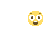

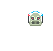

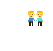

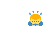

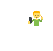

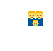

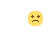

In [37]:
# test run batches generator..
it = get_batches(images, 32)
for i in it:
    plt.figure(figsize=(0.3,0.3))
    plt.imshow(i[2])
    plt.axis("off")

In [9]:
print(images[0].shape)

(64, 64, 4)


## define network


In [47]:
# inputs
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(dtype=tf.float32, shape=(None, *real_dim), name="input_real")
    inputs_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="input_z")

    return inputs_real, inputs_z

In [39]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        fc = tf.layers.dense(inputs=z, units=4*4*512, activation=None)
        conv1 = tf.reshape(fc, shape=(-1, 4, 4, 512))
        conv1 = tf.layers.batch_normalization(inputs=conv1, training=training)
        conv1 = tf.maximum(conv1, alpha*conv1)
        # > 4*4*512
        
        conv2 = tf.layers.conv2d_transpose(inputs=conv1, filters=256, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv2 = tf.layers.batch_normalization(inputs=conv2, training=training)
        conv2 = tf.maximum(conv2, alpha*conv2)
        # > 8*8*256
        
        conv3 = tf.layers.conv2d_transpose(inputs=conv2, filters=128, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv3 = tf.layers.batch_normalization(inputs=conv3, training=training)
        conv3 = tf.maximum(conv3, alpha*conv3)
        # > 16*16*128
        
        conv4 = tf.layers.conv2d_transpose(inputs=conv3, filters=64, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv4 = tf.layers.batch_normalization(inputs=conv4, training=training)
        conv4 = tf.maximum(conv4, alpha*conv4)
        # > 32*32*64
        
        # Output layer, 64*64*4
        logits = tf.layers.conv2d_transpose(inputs=conv4, filters=output_dim, kernel_size=5, strides=2, padding='SAME', activation=None)
        
        out = tf.tanh(logits)
        
        return out

In [40]:
def discriminator(x, reuse=False, alpha=0.2):
    def lRU(x, alpha):
        return tf.maximum(x, x * alpha)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        conv1 = tf.layers.conv2d(inputs=x, filters=64, kernel_size=5, strides=2, activation=None)
        #conv1 = tf.layers.batch_normalization(inputs=conv1, training=True)
        conv1 = tf.maximum(conv1, alpha*conv1)
        # > 16x16x64
        
        conv2 = tf.layers.conv2d(inputs=conv1, filters=128, kernel_size=5, strides=2, activation=None)
        conv2 = tf.layers.batch_normalization(inputs=conv2, training=True)
        conv2 = tf.maximum(conv2, alpha*conv2)
        # > 8x8x256
        
        conv3 = tf.layers.conv2d(inputs=conv2, filters=256, kernel_size=5, strides=2, activation=None)
        conv3 = tf.layers.batch_normalization(inputs=conv3, training=True)
        conv3 = tf.maximum(conv3, alpha*conv3)
        # > 4x4x512
        
        flat = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(inputs=conv3, units=1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [41]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

In [42]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [43]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [44]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [50]:
def train(net, images, epochs, batch_size, print_every=50, show_every=500, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x in get_batches(images, batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 4, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

In [55]:
# hyper params
real_size = (64,64,4)
z_size = 100
learning_rate = 0.0002
batch_size = 64
epochs = 768
alpha = 0.1
beta1 = 0.4

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 13/768... Discriminator Loss: 1.3164... Generator Loss: 1.0055
Epoch 25/768... Discriminator Loss: 0.9770... Generator Loss: 0.9671
Epoch 38/768... Discriminator Loss: 0.8801... Generator Loss: 1.0824
Epoch 50/768... Discriminator Loss: 0.8307... Generator Loss: 1.1662
Epoch 63/768... Discriminator Loss: 0.7484... Generator Loss: 1.2476
Epoch 75/768... Discriminator Loss: 0.7002... Generator Loss: 1.2917
Epoch 88/768... Discriminator Loss: 0.7412... Generator Loss: 1.4401
Epoch 100/768... Discriminator Loss: 1.0270... Generator Loss: 1.3399
Epoch 113/768... Discriminator Loss: 0.7375... Generator Loss: 1.1464
Epoch 125/768... Discriminator Loss: 0.8975... Generator Loss: 1.2172


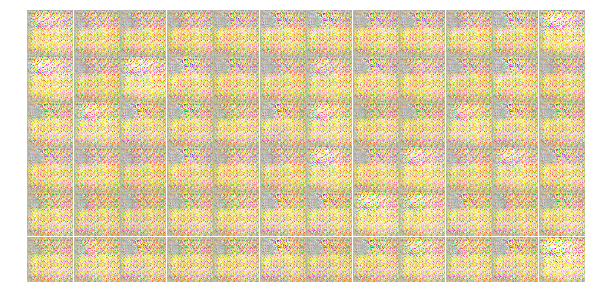

Epoch 138/768... Discriminator Loss: 0.9480... Generator Loss: 1.0739
Epoch 150/768... Discriminator Loss: 1.0025... Generator Loss: 0.9978
Epoch 163/768... Discriminator Loss: 0.7814... Generator Loss: 1.1517
Epoch 175/768... Discriminator Loss: 0.9308... Generator Loss: 1.1069
Epoch 188/768... Discriminator Loss: 1.0207... Generator Loss: 0.8888
Epoch 200/768... Discriminator Loss: 0.8805... Generator Loss: 1.1484
Epoch 213/768... Discriminator Loss: 1.0598... Generator Loss: 1.0300
Epoch 225/768... Discriminator Loss: 0.9905... Generator Loss: 0.8610
Epoch 238/768... Discriminator Loss: 0.8168... Generator Loss: 1.2408
Epoch 250/768... Discriminator Loss: 1.0064... Generator Loss: 1.1353


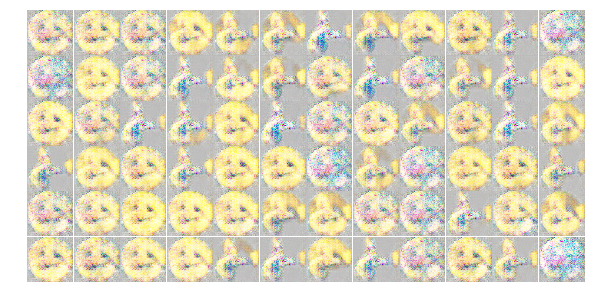

Epoch 263/768... Discriminator Loss: 0.9413... Generator Loss: 1.2472
Epoch 275/768... Discriminator Loss: 1.1756... Generator Loss: 0.7044
Epoch 288/768... Discriminator Loss: 0.8341... Generator Loss: 1.3169
Epoch 300/768... Discriminator Loss: 1.0236... Generator Loss: 0.9585
Epoch 313/768... Discriminator Loss: 1.1154... Generator Loss: 0.9499
Epoch 325/768... Discriminator Loss: 0.9423... Generator Loss: 0.8747
Epoch 338/768... Discriminator Loss: 0.8607... Generator Loss: 0.9147
Epoch 350/768... Discriminator Loss: 1.0411... Generator Loss: 0.7488
Epoch 363/768... Discriminator Loss: 0.9469... Generator Loss: 1.4708
Epoch 375/768... Discriminator Loss: 0.8214... Generator Loss: 1.0995


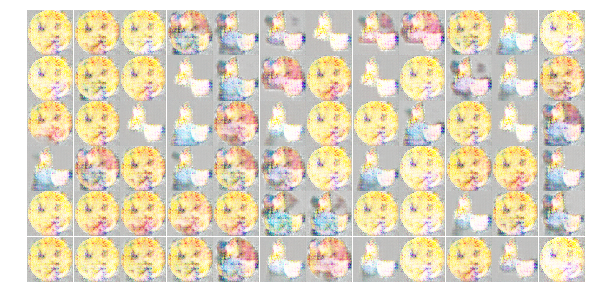

Epoch 388/768... Discriminator Loss: 0.8011... Generator Loss: 1.1967
Epoch 400/768... Discriminator Loss: 0.9046... Generator Loss: 1.3212
Epoch 413/768... Discriminator Loss: 0.7250... Generator Loss: 1.3296
Epoch 425/768... Discriminator Loss: 0.8095... Generator Loss: 1.0325
Epoch 438/768... Discriminator Loss: 0.7198... Generator Loss: 1.6624
Epoch 450/768... Discriminator Loss: 0.7099... Generator Loss: 1.1473
Epoch 575/768... Discriminator Loss: 0.5134... Generator Loss: 1.6861
Epoch 588/768... Discriminator Loss: 0.5317... Generator Loss: 1.4154
Epoch 600/768... Discriminator Loss: 0.8761... Generator Loss: 1.3037
Epoch 613/768... Discriminator Loss: 0.6659... Generator Loss: 1.3013
Epoch 625/768... Discriminator Loss: 0.6947... Generator Loss: 2.0538


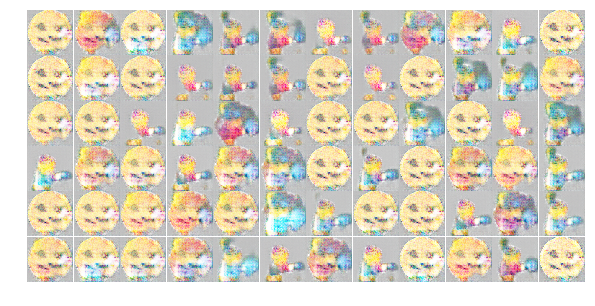

Epoch 638/768... Discriminator Loss: 0.5730... Generator Loss: 1.7333
Epoch 650/768... Discriminator Loss: 0.7741... Generator Loss: 1.4634
Epoch 663/768... Discriminator Loss: 0.7792... Generator Loss: 2.2772
Epoch 675/768... Discriminator Loss: 0.4285... Generator Loss: 1.9977
Epoch 688/768... Discriminator Loss: 1.2016... Generator Loss: 0.8726
Epoch 700/768... Discriminator Loss: 0.5102... Generator Loss: 1.5474
Epoch 713/768... Discriminator Loss: 0.5251... Generator Loss: 1.5535
Epoch 725/768... Discriminator Loss: 0.6027... Generator Loss: 2.1721
Epoch 738/768... Discriminator Loss: 0.3857... Generator Loss: 1.7090
Epoch 750/768... Discriminator Loss: 0.3985... Generator Loss: 1.6771


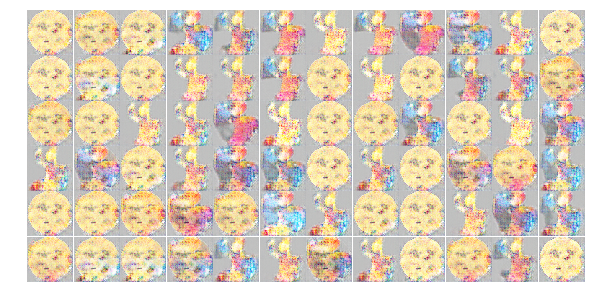

Epoch 763/768... Discriminator Loss: 0.4923... Generator Loss: 1.7715


In [ ]:
# Load the data and train the network here
losses, samples = train(net, images, epochs, batch_size, figsize=(10,5))

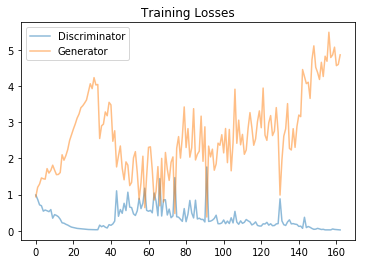

In [54]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

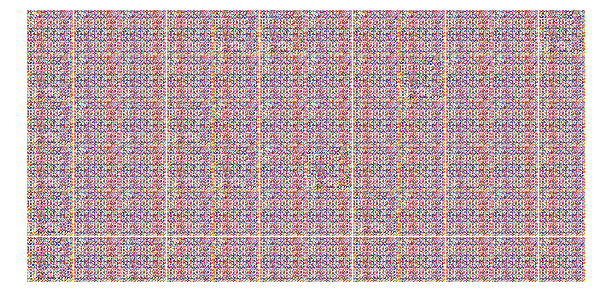

In [53]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))